In [18]:
# from google.colab import drive
# drive.mount('/content/drive')

In [19]:
# ML libraries
import keras
import keras.backend as K
from keras.callbacks import CSVLogger
import tensorflow as tf
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras import Input
from tensorflow.keras.models import *
from tensorflow.keras.layers import Activation,Conv2D,MaxPooling2D,UpSampling2D,Dense,BatchNormalization,Input,Reshape,multiply,add,Dropout,AveragePooling2D,GlobalAveragePooling2D,concatenate
from keras.layers.convolutional import Conv2DTranspose
from keras.regularizers import l2
from tensorflow.keras.layers import Layer, InputSpec
from keras.utils import conv_utils
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.layers.experimental import preprocessing
from sklearn.utils import shuffle
from os import listdir

import matplotlib.pyplot as plt

In [20]:
## CONFIGURATION 
EPOCHS = 5
BUFFER_SIZE = 2000
BATCH_SIZE = 1

IMG_HEIGHT = 128
IMG_WIDTH = 128

In [21]:
# image_dir = "/content/drive/My Drive/3d printer/codes/datasets/cropped-datasets/"
# masks_dir = "/content/drive/My Drive/3d printer/codes/datasets/ground-truth/"

image_dir = "./All_images/"
masks_dir = "./All_masks/"

In [22]:
# choose on of the pairs of data and mask for dataset

# img_folders = ['abyek_images', 'Khorasan_part1_images', 'Khorasan_part2_images', 'bound_images', 'France_images', 'orthophoto_images']
# mask_folders = ['abyek_masks', 'Khorasan_part1_masks', 'Khorasan_part2_masks', 'bound_masks', 'France_masks', 'orthophoto_masks']

img_folders = ['abyek_images', 'Khorasan_part1_images', 'Khorasan_part2_images']
mask_folders = ['abyek_masks', 'Khorasan_part1_masks', 'Khorasan_part2_masks']

# img_folders = ['abyek_images', 'Khorasan_part1_images',  'deliniation_images', 'bound_images']
# mask_folders = ['abyek_masks', 'Khorasan_part1_masks', 'deliniation_masks', 'bound_masks']

# img_folders = ['abyek_images']
# mask_folders = ['abyek_masks']


images_path, masks_path = [], []
# loop in pair of data and mask to make list of images and masks based on folder image
for fol, mfol in zip(img_folders, mask_folders):
    images_list = listdir(image_dir + fol)
    masks_list = listdir(masks_dir + mfol)

    img_list = [i.split('.jpg')[0] for i in images_list]
    msk_list = [i.split('.png')[0] for i in masks_list]

    commons = list(set(img_list) & set(msk_list))

    shuffle(commons)
    
    # commons = commons[:1200]

    print(len(commons))

    ip =  [image_dir + fol + "/" + i + ".jpg"  for i in commons]
    mp  = [masks_dir + mfol + "/" + i + ".png"  for i in commons]
    # print(len(ip), len(mp))

    images_path.extend(ip)
    masks_path.extend(mp)
    # print(len(images_path), len(masks_path))

1155
1001
1287


In [23]:
masks_path[:10], images_path[:10]

(['./All_masks/abyek_masks/20.png',
  './All_masks/abyek_masks/1116.png',
  './All_masks/abyek_masks/143.png',
  './All_masks/abyek_masks/892.png',
  './All_masks/abyek_masks/752.png',
  './All_masks/abyek_masks/680.png',
  './All_masks/abyek_masks/1441.png',
  './All_masks/abyek_masks/1096.png',
  './All_masks/abyek_masks/1235.png',
  './All_masks/abyek_masks/890.png'],
 ['./All_images/abyek_images/20.jpg',
  './All_images/abyek_images/1116.jpg',
  './All_images/abyek_images/143.jpg',
  './All_images/abyek_images/892.jpg',
  './All_images/abyek_images/752.jpg',
  './All_images/abyek_images/680.jpg',
  './All_images/abyek_images/1441.jpg',
  './All_images/abyek_images/1096.jpg',
  './All_images/abyek_images/1235.jpg',
  './All_images/abyek_images/890.jpg'])

In [24]:
def load_images(image_path, mask_path, img_size = (IMG_HEIGHT, IMG_WIDTH)):
  # load our images from the image and mask path
  img_data = tf.io.read_file(image_path)
  img = tf.io.decode_png(img_data,channels=3)
  img = tf.image.convert_image_dtype(img,tf.float32)

  segm_data = tf.io.read_file(mask_path)
  mask = tf.io.decode_png(segm_data)
  mask = tf.math.reduce_max(mask, axis = -1, keepdims=True)
  mask = mask / 255

  img = tf.image.resize(img, img_size , method = 'nearest')
  mask = tf.image.resize(mask, img_size, method = 'nearest')
  
  return img, mask

In [25]:
dataset = tf.data.Dataset.from_tensor_slices((images_path, masks_path))
dataset = dataset.map(load_images ,num_parallel_calls = tf.data.AUTOTUNE).batch(BATCH_SIZE).shuffle(BUFFER_SIZE).cache()

In [26]:
seed = 123
# divide our dataset into training and test set
val_dataset = (dataset
               .take(300)
               .prefetch(buffer_size=tf.data.AUTOTUNE) 
               )
train_dataset = (dataset
                .skip(300)
                .map(lambda image, mask: (tf.image.random_flip_up_down(image, seed=seed), tf.image.random_flip_up_down(mask, seed=seed)))
                .map(lambda image, label: (tf.image.random_flip_left_right(image, seed=seed), tf.image.random_flip_left_right(label, seed=seed)))
                .map(lambda image, label: (tf.image.random_contrast(image, lower=0.5, upper=0.8), label))               
                .prefetch(buffer_size=tf.data.AUTOTUNE)
                .repeat(5)
                ) 
# train_dataset = train_dataset.map(lambda image, mask: (tf.image.random_flip_up_down(image, seed=seed), tf.image.random_flip_up_down(mask, seed=seed))).repeat(1)

2024-04-29 14:49:36.255789: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


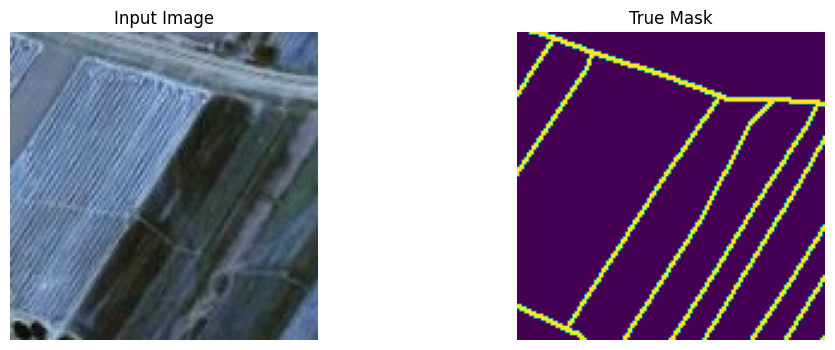

In [27]:
# plot images
def display(display_list, num_plot, flag=False):
  plt.figure(figsize=(12,4))
  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  if flag:
    plt.savefig(f"./Result_plots/result_img_densenet_{num_plot}.png")
    
N = 1
for image,mask in dataset.take(N):
  sample_image, sample_mask = image[0],mask[0]
  display([sample_image,sample_mask], False)
  

##  Model


In [28]:
# Code credit: https://github.com/mad-Ye/FC-DenseNet-Keras/blob/master/layers.py
def BN_ReLU_Conv(inputs, n_filters, filter_size=3, dropout_p=0.2):
    '''
    Apply BatchNormalization, ReLU nonlinearity, Convolution and Dropout successively
    Dense block layers are composed of BN, followed by ReLU, a 3x3 same convolution (no resolution loss)
    and dropoutwith probability p=0.2
    '''
    l = BatchNormalization()(inputs)
    l = Activation('relu')(l)
    l = Conv2D(n_filters, filter_size, padding='same', kernel_initializer='he_uniform')(l)
    if dropout_p != 0.0: 
        l = Dropout(dropout_p)(l)
    return l 

def TransitionDown(inputs, n_filters, dropout_p=0.2): 
    '''Apply a BN_ReLU_Conv layer with filter size = 1, and a max pooling with a factor of 2'''
    l = BN_ReLU_Conv(inputs, n_filters, filter_size=1, dropout_p=dropout_p)
    l = MaxPooling2D((2,2))(l)
    return l 

def TransitionUp(skip_connection, block_to_upsample, n_filters_keep): 
    '''Performs upsampling on block_to_upsample by a factor 2 and concatenates it with the skip_connection'''
    l = Conv2DTranspose(n_filters_keep, kernel_size=3, strides=2, padding='same', kernel_initializer='he_uniform')(block_to_upsample)
    l = concatenate([l, skip_connection], axis=-1)
    return l

def SoftmaxLayer(inputs, n_classes): 
    '''
    Performs 1x1 convolution followed by softmax nonlinearity 
    The output will have the shape (batch_size x n_rows x n_cols, n_classes)
    '''
    l = Conv2D(n_classes, kernel_size=1, padding='same', kernel_initializer='he_uniform', activation='sigmoid')(inputs)
    # l = Reshape((-1, n_classes))(l)
    # l = Activation('softmax') # 'sigmoid' for binary classes
    return l

In [29]:
def build_FC_DenseNets(input_shape=(None,None,2),
                       n_classes=1, 
                       n_filters_first_conv=48, 
                       n_pool=5, 
                       growth_rate=16,
                       n_layers_per_block= [4, 5, 7, 10, 7, 5, 4], #[4, 5, 7, 10, 12, 15, 12, 10, 7, 5, 4],
                       dropout_p=0.2):
    if type(n_layers_per_block) == list:
            print(len(n_layers_per_block))
    elif type(n_layers_per_block) == int:
            n_layers_per_block = [n_layers_per_block] * (2 * n_pool + 1)
    else:
        raise ValueError
    
#####################
# First Convolution #
#####################        
    inputs = Input(shape=input_shape)
    stack = Conv2D(filters=n_filters_first_conv, kernel_size=3, padding='same', kernel_initializer='he_uniform')(inputs)
    n_filters = n_filters_first_conv

#####################
# Downsampling path #
#####################  
    skip_connection_list = []
    for i in range(n_pool): # each iteration creates a dense block in the down path
        for j in range(n_layers_per_block[i]): # each iteration composes layers for a dense block
            l = BN_ReLU_Conv(stack, growth_rate, dropout_p=dropout_p)      
            stack = concatenate([stack, l])
            n_filters += growth_rate   

        skip_connection_list.append(stack)
        stack = TransitionDown(stack, n_filters, dropout_p)
    skip_connection_list = skip_connection_list[::-1] # reverse the skip_connection_list for upsampling

#####################
#    Bottleneck     #
#####################     
    block_to_upsample = []

    for j in range(n_layers_per_block[n_pool]):
        l = BN_ReLU_Conv(stack, growth_rate, dropout_p=dropout_p)
        block_to_upsample.append(l) 
        stack = concatenate([stack, l])
    block_to_upsample = concatenate(block_to_upsample)

#####################
#  Upsampling path  #
#####################
    for i in range(n_pool): 
        n_filters_keep = growth_rate * n_layers_per_block[n_pool + i]
        stack = TransitionUp(skip_connection_list[i], block_to_upsample, n_filters_keep)

        block_to_upsample = []
        for j in range(n_layers_per_block[n_pool + i + 1]): 
            l = BN_ReLU_Conv(stack, growth_rate, dropout_p=dropout_p)
            block_to_upsample.append(l)
            stack = concatenate([stack, l])
        block_to_upsample = concatenate(block_to_upsample)

#####################
#  Softmax          #
#####################
    output = SoftmaxLayer(stack, n_classes)
    model = Model(inputs = inputs, outputs = output)
    # model.summary()

    return model

In [30]:
model = build_FC_DenseNets(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                        n_classes=1, 
                        n_filters_first_conv=48, 
                        n_pool=5, 
                        growth_rate=16,
                        # n_layers_per_block= [4, 5, 7, 10, 7, 5, 4],
                        n_layers_per_block=[4, 5, 7, 10, 12, 15, 12, 10, 7, 5, 4],
                        dropout_p=0.2)

11


In [31]:
from tensorflow.keras.optimizers import Adam
import keras.backend as K



def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_score(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

# calculate iou metric
iou = tf.keras.metrics.IoU(num_classes=2, target_class_ids=[0])


# compile the model 
model.compile(
     optimizer=Adam(learning_rate=0.001),
        loss="binary_crossentropy",
        # loss="mse",
        # loss = weightedLoss(keras.losses.binary_crossentropy, [1.0, 50.0]),
        metrics=["accuracy", "Precision", "Recall", f1_score],
        # sample_weight_mode="temporal",
  )

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_98 (Conv2D)             (None, 128, 128, 48  1344        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_96 (BatchN  (None, 128, 128, 48  192        ['conv2d_98[0][0]']              
 ormalization)                  )                                                           

In [33]:
# make checkpoint to save model in each epoch
callbacks = [
    # ReduceLROnPlateau(patience=3, verbose=1),
    # EarlyStopping(patience=12, verbose=1),
    ModelCheckpoint('densenet-model.h5', verbose=0, save_freq="epoch", save_best_only=True,save_weights_only=False)
    ]

In [34]:
  # fiting the model
history = model.fit(
      train_dataset,
      epochs=EPOCHS,
      validation_data = val_dataset,
      # validation_steps = 8,
      callbacks = callbacks, 
    )

Epoch 1/5


15715/15715 [==============================] - 1005s 63ms/step - loss: 0.1809 - accuracy: 0.9364 - precision: 0.5996 - recall: 0.1766 - f1_score: 0.1782 - val_loss: 0.2208 - val_accuracy: 0.9313 - val_precision: 0.6015 - val_recall: 0.1566 - val_f1_score: 0.1929
Epoch 2/5
15715/15715 [==============================] - 1009s 64ms/step - loss: 0.1530 - accuracy: 0.9419 - precision: 0.6473 - recall: 0.3064 - f1_score: 0.2792 - val_loss: 0.2917 - val_accuracy: 0.9313 - val_precision: 0.6289 - val_recall: 0.1270 - val_f1_score: 0.1582
Epoch 3/5
15715/15715 [==============================] - 1010s 64ms/step - loss: 0.1383 - accuracy: 0.9455 - precision: 0.6706 - recall: 0.3799 - f1_score: 0.3397 - val_loss: 0.2433 - val_accuracy: 0.9317 - val_precision: 0.6196 - val_recall: 0.1489 - val_f1_score: 0.2025
Epoch 4/5
15715/15715 [==============================] - 1010s 64ms/step - loss: 0.1264 - accuracy: 0.9486 - precision: 0.6861 - recall: 0.4396 - f1_score: 0.3894 - val_loss: 0.2608 - val_acc

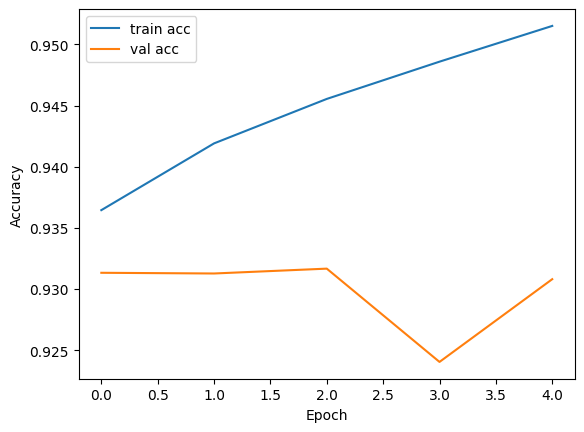

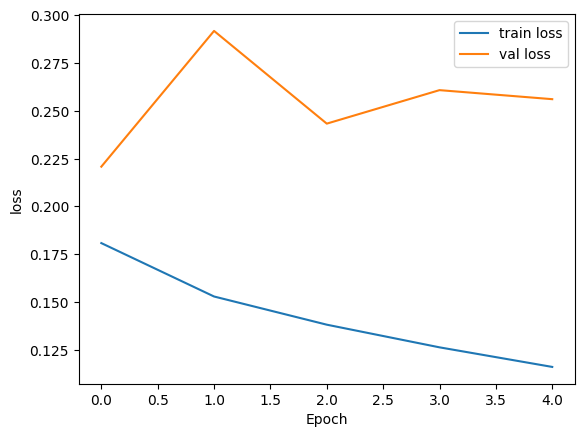

In [35]:
# plot the accuracy and loss plots for train and test data

plt.plot(history.history["accuracy"], label='train acc')
plt.plot(history.history["val_accuracy"], label='val acc')
# plt.ylim([0.93, 1])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(f"./Result_plots/result_dense_acc.png")
plt.show()

plt.plot(history.history["loss"], label='train loss')
plt.plot(history.history["val_loss"], label='val loss')
# plt.ylim([0.93, 1])
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig(f"./Result_plots/result_dense_loss.png")
plt.show()

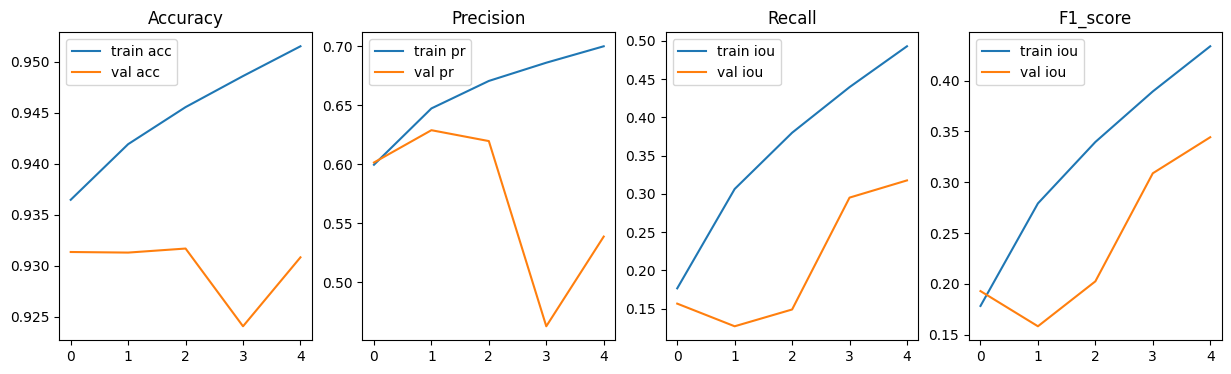

In [36]:
# plot accuracy, precision and IOU  

fig , ax = plt.subplots(1, 4, figsize=(15, 4))

ax[0].plot(history.history["accuracy"], label='train acc')
ax[0].plot(history.history["val_accuracy"], label='val acc')
ax[0].set_title('Accuracy')
ax[0].legend()

ax[1].plot(history.history["precision"], label='train pr')
ax[1].plot(history.history["val_precision"], label='val pr')
ax[1].set_title('Precision')
ax[1].legend()

ax[2].plot(history.history["recall"], label='train iou')
ax[2].plot(history.history["val_recall"], label='val iou')
ax[2].set_title('Recall')
ax[2].legend()

ax[3].plot(history.history["f1_score"], label='train iou')
ax[3].plot(history.history["val_f1_score"], label='val iou')
ax[3].set_title('F1_score')
ax[3].legend()

plt.savefig(f"./Result_plots/result_densenet_final.png")
plt.show()

In [37]:
def create_mask(pred_mask):
    # pred_mask = tf.argmax(pred_mask, axis=-1)
    pred = pred_mask[0]
    pred[pred >= 0.5] = 1
    pred[pred < 0.5] = 0

    # pred_mask = pred_mask[..., tf.newaxis]
    return pred

In [38]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        counter = 0
        for image, mask in dataset.take(num):
            pred_mask = model.predict(image, verbose=0)
            # print(pred_mask[0][pred_mask[0]>0.5])
            display([image[0], mask[0], create_mask(pred_mask)], counter, True)
            counter += 1
    else:
        display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

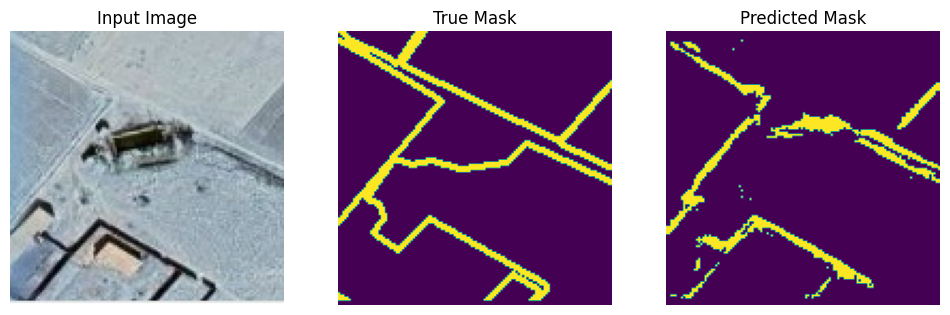

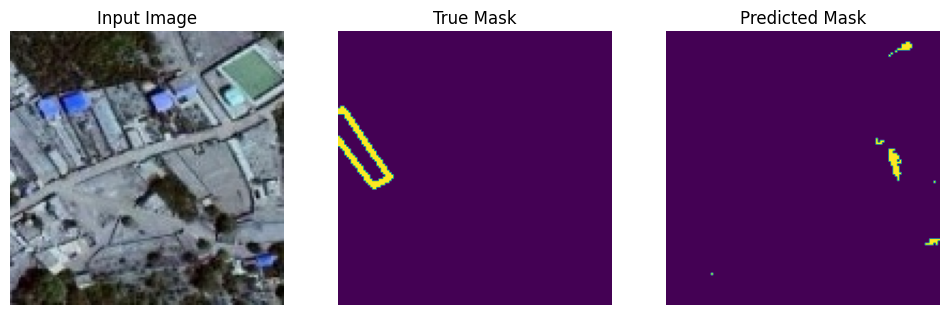

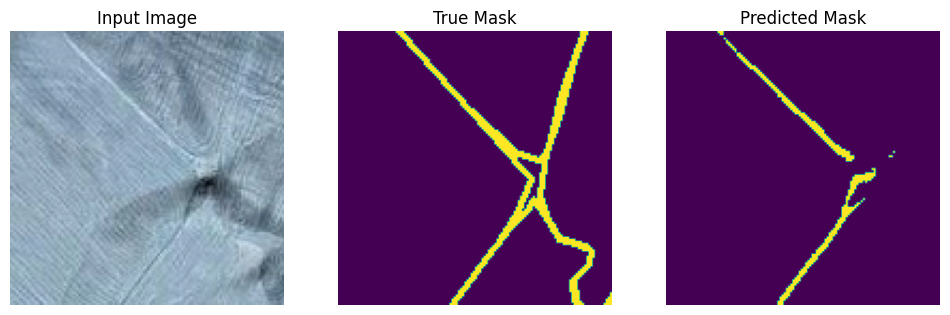

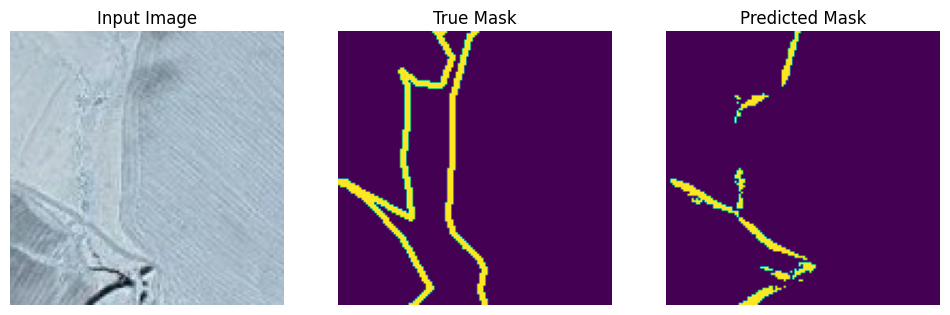

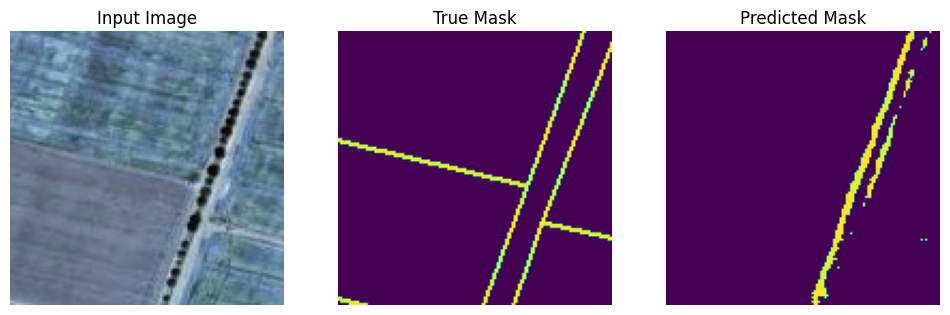

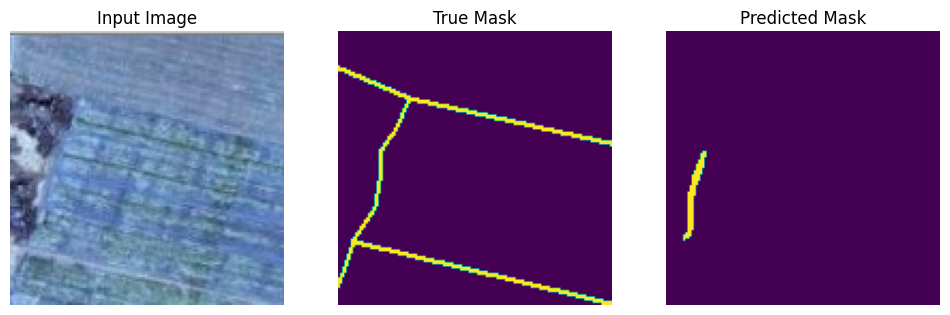

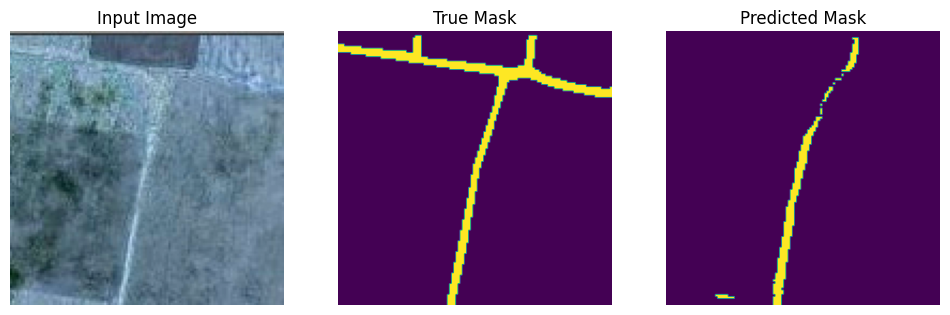

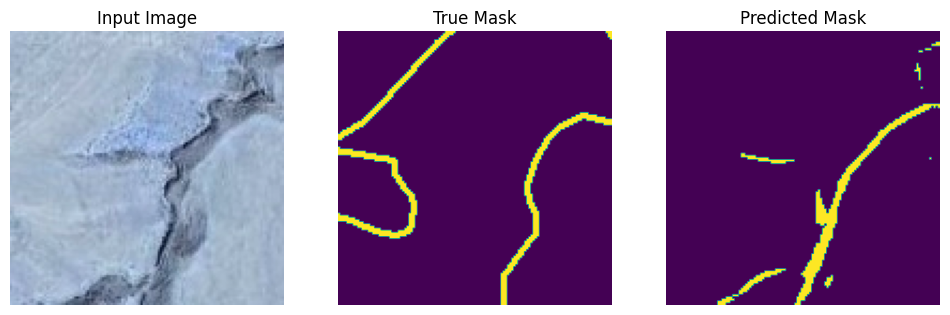

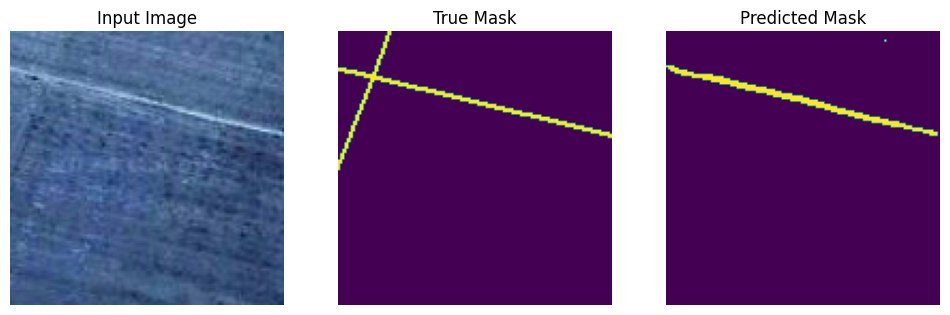

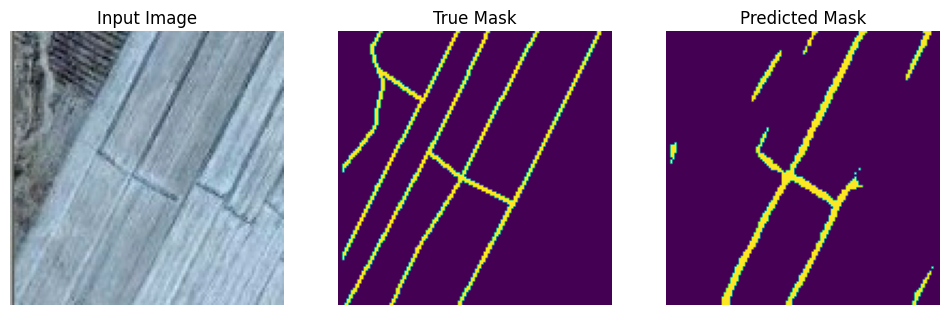

In [43]:
## displaying our result
show_predictions(val_dataset,num=10)